# Solving a Fourth Order Elliptic Singular Perturbation Problem

In [207]:
from skfem import *
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov
from skfem.helpers import dd, ddot, grad
from scipy.sparse.linalg import LinearOperator, minres
from skfem import *
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.dpi'] = 100

## Problem 1

The modified Morley-Wang-Xu element method is equivalent to finding $w_{h} \in W_{h}$ and $u_{h 0} \in V_{h 0}$ such that
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h} \\
\varepsilon^{2} a_{h}\left(u_{h 0}, v_{h}\right)+b_{h}\left(u_{h 0}, v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) & & \forall v_{h} \in V_{h 0}
\end{aligned}
$$
where 
$$
a_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h 0}, \nabla_{h}^{2} v_{h}\right), \quad b_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h} u_{h 0}, \nabla_{h} v_{h}\right)
$$

Using example 
$$
u\left(x_{1}, x_{2}\right)=\left(\sin \left(\pi x_{1}\right) \sin \left(\pi x_{2}\right)\right)^{2}
$$

### Setting $\epsilon$ and generating mesh

In [210]:
epsilon = 0

m = MeshTri()
m.refine(6)
element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
basis = {variable: InteriorBasis(m, e, intorder=4)
    for variable, e in element.items()}  # intorder: integration order for quadrature

# draw(m)
# plt.show()

### Exact $u$

In [211]:
def exact_u(x, y):
    return (np.sin(np.pi * x) * np.sin(np.pi * y))**2

### Forms for $\left(\nabla w_{h}, \nabla \chi_{h}\right)=\left(f, \chi_{h}\right)$

In [212]:
@BilinearForm
def laplace(u, v, w):
    '''
    for $(\nabla w_{h}, \nabla \chi_{h})$
    '''
    return dot(grad(u), grad(v))


@LinearForm
def f_load(v, w):
    '''
    for $(f, x_{h})$
    '''
    pix = np.pi * w.x[0]
    piy = np.pi * w.x[1]
    lu = 2*(np.pi)**2 * (np.cos(2*pix)*np.sin(piy)**2 + np.cos(2*piy)*np.sin(pix)**2)
    llu = -8*(np.pi)**4 * (np.cos(2*pix)*np.sin(piy)**2 + np.cos(2*piy)*np.sin(pix)**2 - np.cos(2*pix)*np.cos(2*piy))
    return epsilon**2 * llu - lu

### Solving $w_{h}$

In [213]:
%%time

K1 = asm(laplace, basis['w'])
f1 = asm(f_load, basis['w'])

wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))

build_pc_diag(A) enabled
Wall time: 64.9 ms


### Forms for $\varepsilon^{2} a_{h}\left(u_{h 0}, v_{h}\right)+b_{h}\left(u_{h 0}, v_{h}\right)=\left(\nabla w_{h}, \nabla_{h} v_{h}\right)$

$$
a_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h 0}, \nabla_{h}^{2} v_{h}\right), \quad b_{h}\left(u_{h 0}, v_{h}\right):=\left(\nabla_{h} u_{h 0}, \nabla_{h} v_{h}\right)
$$

In [214]:
@BilinearForm
def a_load(u, v, w):
    '''
    for $a_{h}$
    '''
    return ddot(dd(u), dd(v))


@BilinearForm
def b_load(u, v, w):
    '''
    for $b_{h}$
    '''
    return dot(grad(u), grad(v))


@BilinearForm
def wv_load(u, v, w):
    '''
    for $(\nabla \chi_{h}, \nabla_{h} v_{h})$
    '''
    return dot(grad(u), grad(v))

### Setting boundary conditions

In [215]:
def easy_boundary(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))
    return D

### Solving $u_{h0}$

In [216]:
%%time

D = easy_boundary(basis['u'])
K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
f2 = asm(wv_load, basis['w'], basis['u']) * wh
uh0 = solve(*condense(K2, f2, D=D), solver=solver_iter_krylov(Precondition=True))

build_pc_diag(A) enabled
Wall time: 313 ms


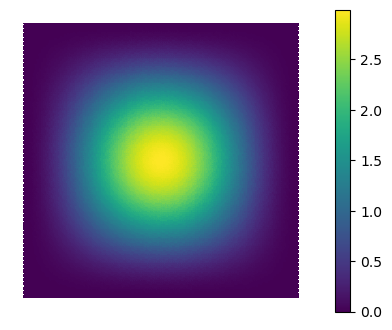

In [217]:
plot(basis['u'], uh0, colorbar=True)
plt.show()

### Showing exact $u$

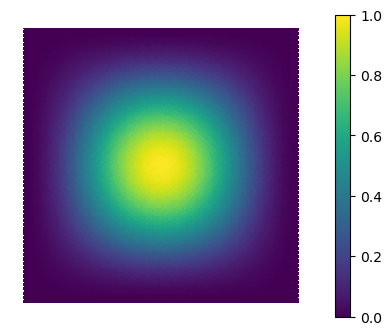

In [218]:
u = exact_u(basis['u'].doflocs[0], basis['u'].doflocs[1])

plot(basis['u'], u, colorbar=True)
plt.show()

### Visualizing error with $\frac{u_{h0}}{3}$

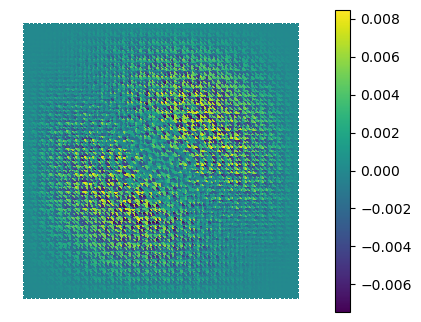

In [219]:
plot(basis['u'], u-uh0/3, colorbar=True)
plt.show()

### Computing $L_{2}$ error with $\frac{u_{h0}}{3}$ and $u$

In [187]:
@Functional
def L2uError(w):
    x, y = w.x
    return (w.w/3 - exact_u(x, y))**2

In [191]:
U = basis['u'].interpolate(uh0).value

L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
print('L2 error of uh0:', L2u)

L2 error of uh0: 9.45735949297556e-05


 - Experiment with $$\epsilon = 1$$

In [203]:
epsilon = 1

currentL2u = 1
formerL2u = 1
m = MeshTri()

for i in range(1, 6):
    m.refine()

    element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    basis = {variable: InteriorBasis(m, e, intorder=4)
        for variable, e in element.items()}  # intorder: integration order for quadrature

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))

    D = easy_boundary(basis['u'])
    K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    uh0 = solve(*condense(K2, f2, D=D), solver=solver_iter_krylov(Precondition=True))

    U = basis['u'].interpolate(uh0).value

    L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
    print('case 2^-' + str(i))
    print('L2 error of uh0:', L2u)
    currentL2u = L2u
    if i != 1:
        print('rate', -np.log2(currentL2u/formerL2u))
    formerL2u = L2u

build_pc_diag(A) enabled
build_pc_diag(A) enabled
case 2^-1
L2 error of uh0: 0.3053056975204082
build_pc_diag(A) enabled
build_pc_diag(A) enabled
case 2^-2
L2 error of uh0: 0.0925598803790994
rate 1.7217956078495706
build_pc_diag(A) enabled
build_pc_diag(A) enabled
case 2^-3
L2 error of uh0: 0.024051351828304538
rate 1.9442690156887794
build_pc_diag(A) enabled
build_pc_diag(A) enabled
case 2^-4
L2 error of uh0: 0.005994968114556966
rate 2.004293998764181
build_pc_diag(A) enabled
build_pc_diag(A) enabled
case 2^-5
L2 error of uh0: 0.0014949503232293947
rate 2.0036545355189888


 - Experiment with $$\epsilon = 0$$

In [205]:
epsilon = 0

currentL2u = 1
formerL2u = 1
m = MeshTri()

for i in range(1, 6):
    m.refine()

    element = {'w': ElementTriP1(), 'u': ElementTriMorley()}
    basis = {variable: InteriorBasis(m, e, intorder=4)
        for variable, e in element.items()}  # intorder: integration order for quadrature

    K1 = asm(laplace, basis['w'])
    f1 = asm(f_load, basis['w'])

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))

    D = easy_boundary(basis['u'])
    K2 = epsilon**2 * asm(a_load, basis['u']) + asm(b_load, basis['u'])
    f2 = asm(wv_load, basis['w'], basis['u']) * wh
    uh0 = solve(*condense(K2, f2, D=D), solver=solver_iter_krylov(Precondition=True))

    U = basis['u'].interpolate(uh0).value

    L2u = np.sqrt(L2uError.assemble(basis['u'], w=U))
    print('case 2^-' + str(i))
    print('L2 error of uh0:', L2u)
    currentL2u = L2u
    if i != 1:
        print('rate', -np.log2(currentL2u/formerL2u))
    formerL2u = L2u

build_pc_diag(A) enabled
build_pc_diag(A) enabled
case 2^-1
L2 error of uh0: 0.3190530969913223
build_pc_diag(A) enabled
build_pc_diag(A) enabled
case 2^-2
L2 error of uh0: 0.106488225500884
rate 1.5831026188922919
build_pc_diag(A) enabled
build_pc_diag(A) enabled
case 2^-3
L2 error of uh0: 0.026257805710669217
rate 2.019875654674116
build_pc_diag(A) enabled
build_pc_diag(A) enabled
case 2^-4
L2 error of uh0: 0.006231892125251031
rate 2.075004193875261
build_pc_diag(A) enabled
build_pc_diag(A) enabled
case 2^-5
L2 error of uh0: 0.001524934295446471
rate 2.0309231775151604


## Problem 2

The modified Morley-Wang-Xu element method is also equivalent to
$$
\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h} \\
\varepsilon^{2} \tilde{a}_{h}\left(u_{h}, v_{h}\right)+b_{h}\left(u_{h}, v_{h}\right) &=\left(\nabla w_{h}, \nabla_{h} v_{h}\right) & & \forall v_{h} \in V_{h}
\end{aligned}
$$
where
$$
\tilde{a}_{h}\left(u_{h}, v_{h}\right):=\left(\nabla_{h}^{2} u_{h}, \nabla_{h}^{2} v_{h}\right)-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n n}^{2} u_{h}, \partial_{n} v_{h}\right)_{F}-\sum_{F \in \mathcal{F}_{h}^{\partial}}\left(\partial_{n} u_{h}, \partial_{n n}^{2} v_{h}\right)_{F}+\sum_{F \in \mathcal{F}_{h}^{0}} \frac{\sigma}{h_{F}}\left(\partial_{n} u_{h}, \partial_{n} v_{h}\right)_{F}
$$

## From Poisson

In [11]:
@BilinearForm
def laplace(u, v, w):
    return dot(grad(u), grad(v))


@LinearForm
def unit_load(v, w):
    return v

build_pc_diag(A) enabled


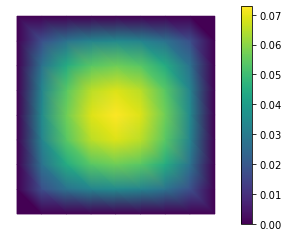

Wall time: 123 ms


In [12]:
%%time

m = MeshTri()
m.refine(3)

e = ElementTriP1()
basis = InteriorBasis(m, e)

A = asm(laplace, basis)
b = asm(unit_load, basis)

x2 = solve(*condense(A, b, D=m.boundary_nodes()), solver=solver_iter_krylov(Precondition=True))

plot(m, x2, shading='gouraud', colorbar=True)
plt.show()

## From Biharmonic

### boundary and forms

In [13]:
def easy_boundary(basis):
    '''
    Input basis
    ----------------
    Return D for boundary conditions
    '''

    dofs = basis.find_dofs({
        'left': m.facets_satisfying(lambda x: x[0] == 0),
        'right': m.facets_satisfying(lambda x: x[0] == 1),
        'top': m.facets_satisfying(lambda x: x[1] == 1),
        'buttom': m.facets_satisfying(lambda x: x[1] == 0)
    })

    D = np.concatenate((dofs['left'].nodal['u'], dofs['right'].nodal['u'],
                        dofs['top'].nodal['u'], dofs['buttom'].nodal['u'],
                        dofs['left'].facet['u_n'], dofs['right'].facet['u_n'],
                        dofs['top'].facet['u_n'], dofs['buttom'].facet['u_n']))
    return D


@BilinearForm
def bilinf(u, v, w):
    '''
    for k in biharmonic
    '''
    return ddot(dd(u), dd(v))


@LinearForm
def mybih(v, w):
    '''
    for f
    '''
    x, y = w.x
    return (24 * ((x**2 - x + 1)**2 + (y**2 - y + 1)**2 + 12 * (x - 1) *
                  (y - 1) * x * y) - 40) * v

### Defining exact $u$ $Du$ and $D^{2}u$

In [14]:
def exact(x, y):
    return (x * y * (1 - x) * (1 - y))**2


def dexact(x, y):
    dux = (y * (1 - y))**2 * (4 * x**3 - 6 * x**2 + 2 * x)
    duy = (x * (1 - x))**2 * (4 * y**3 - 6 * y**2 + 2 * y)
    return dux, duy


def ddexact(x, y):
    duxx = (12 * x**2 - 12 * x + 2) * (y * (1 - y))**2 
    duxy = (4 * x**3 - 6 * x**2 + 2 * x) * (4 * y**3 - 6 * y**2 + 2 * y)
    duyx = duxy
    duyy = (12 * y**2 - 12 * y + 2) * (x * (1 - x))**2 
    return duxx, duxy, duyx, duyy

In [15]:
%%time
m = MeshTri()
m.refine(3)

e = ElementTriMorley()
ib = InteriorBasis(m, e)

K = asm(bilinf, ib)
f = asm(mybih, ib)
D = easy_boundary(ib)

uh = solve(*condense(K, f, D=D), solver=solver_iter_krylov())

Wall time: 23.9 ms


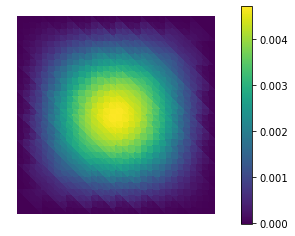

In [16]:
plot(ib, uh, colorbar=True, Nrefs=2)
plt.show()